Data shape: (354694, 20)
Columns: ['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask', 'Volume_Delta', 'Volume_Delta_abs', 'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta', 'New_day', 'New_week', 'Y_High_Bid', 'Y_Low_Ask']
N (window length): 50
t (features): 18
L (number of samples): 29945
X shape: (29945, 50, 18)
Y shape: (29945, 2)
Train samples: 23956
Test samples: 5989
LSTM units (ZY + 10): 73


C:\Users\sudha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 73)                  │          26,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,298 (114.45 KB)

 Trainable params: 29,298 (114.45 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3646 - mae: 0.2859 - mse: 0.3646
Epoch 1: val_loss improved from None to 0.00078, saving model to best_model_LSTM_GOLD.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.0830 - mae: 0.0816 - mse: 0.0830 - val_loss: 7.7797e-04 - val_mae: 0.0274 - val_mse: 7.7797e-04
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.8367e-04 - mae: 0.0109 - mse: 1.8367e-04
Epoch 2: val_loss improved from 0.00078 to 0.00068, saving model to best_model_LSTM_GOLD.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1.8173e-04 - mae: 0.0108 - mse: 1.8173e-04 - val_loss: 6.8219e-04 - val_mae: 0.0255 - val_mse: 6.8219e-04
Epoch 3/10
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7539e-04 - mae: 0.0106 - mse: 1.7539e-04
Epoch 3: val_loss did not improve from 0.00068
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 1.7434e-04 - mae: 0.0106 - mse: 1.7434e-04 - val_loss: 7.6538e-04 - val_mae: 0.0271 - val_mse: 7.653

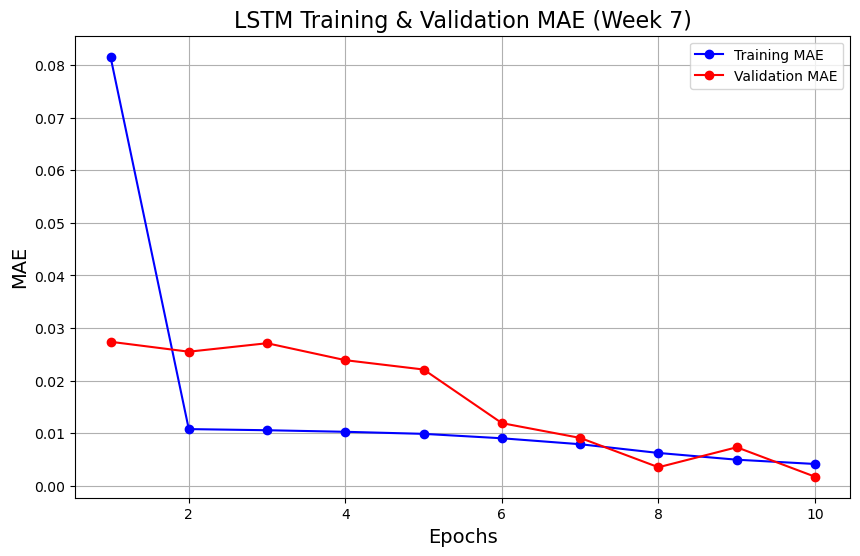

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---------------------------------------------------------
# 1. Load normalised GOLD data
# ---------------------------------------------------------
data_path = "GOLD_2022_normalised_NEW-1000.csv"   # adjust path if needed
df = pd.read_csv(data_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Feature columns (18) and target columns (2) – same as practical
feature_cols = [
    'Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid',
    'Open_Ask', 'High_Ask', 'Low_Ask', 'Close_Ask', 'Volume_Ask',
    'Volume_Delta', 'Volume_Delta_abs',
    'Open_Delta', 'High_Delta', 'Low_Delta', 'Close_Delta',
    'New_day', 'New_week'
]
target_cols = ['Y_High_Bid', 'Y_Low_Ask']

data_features = df[feature_cols].values.astype('float32')
data_targets  = df[target_cols].values.astype('float32')

# ---------------------------------------------------------
# 2. Build 3D tensor of sequences (N = 50 minutes) & Y targets
#    Follow the comments in the practical notebook
# ---------------------------------------------------------
N = 50                 # sequence length (minutes) – from notebook
n_small = 30000        # use first 30,000 minutes (≈ 1 month), same idea as notes

data_a = data_features[:n_small, :]   # shape: (n_small, 18)
data_y = data_targets[:n_small, :]    # shape: (n_small, 2)

t = data_a.shape[1]                   # number of features = 18
L = n_small - N - 5                   # as in comments: n_small - N - 5

print("N (window length):", N)
print("t (features):", t)
print("L (number of samples):", L)

# 3D tensor for LSTM input and 2D matrix for answers
X = np.zeros((L, N, t), dtype='float32')
Y = np.zeros((L, 2), dtype='float32')

for k in range(L):
    X[k, :, :] = data_a[k:k + N, :]
    # Y at k+N-1 = future (during next 5 minutes) normalised prices
    Y[k, 0] = data_y[k + N - 1, 0]  # Y_High_Bid
    Y[k, 1] = data_y[k + N - 1, 1]  # Y_Low_Ask

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# ---------------------------------------------------------
# 3. Train / test split (time-series: no shuffle)
# ---------------------------------------------------------
train_size = int(0.8 * L)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# ---------------------------------------------------------
# 4. LSTM units from SID (XXXXXXZY) – YOUR SID 2421463
# ---------------------------------------------------------
sid = "2421463"
Z = int(sid[-2])          # 6
Y_digit = int(sid[-1])    # 3

lstm_base = int(f"{Z}{Y_digit}")      # "63"
lstm_units = lstm_base + 10           # 63 + 10 = 73

print("LSTM units (ZY + 10):", lstm_units)

# ---------------------------------------------------------
# 5. Build LSTM model (practical model with parameter 100 → 73 now)
# ---------------------------------------------------------
model = Sequential()
model.add(
    LSTM(
        units=lstm_units,            # ← changed from 100 to 73 (requirement 1)
        input_shape=(N, t),
        return_sequences=False
    )
)
# You can add more Dense layers if they were in your practical model;
# here we keep a simple, typical structure.
model.add(Dense(32, activation='relu'))
model.add(Dense(2))   # output: [Y_High_Bid, Y_Low_Ask]

# ---------------------------------------------------------
# 6. Compile model (track both MSE & MAE)
# ---------------------------------------------------------
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse', 'mae']
)

print(model.summary())

# ---------------------------------------------------------
# 7. EarlyStopping & ModelCheckpoint
#    Change patience to 3 (requirement 4)
# ---------------------------------------------------------
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,             # ← changed from 5 to 3
    verbose=1,
    restore_best_weights=True
)

mc = ModelCheckpoint(
    'best_model_LSTM_GOLD.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

# ---------------------------------------------------------
# 8. Train the model
#    Change epochs to 10 (requirement 3)
# ---------------------------------------------------------
EPOCHS = 10

history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, mc],
    verbose=1
)

# ---------------------------------------------------------
# 9. Evaluate test MSE & MAE
# ---------------------------------------------------------
test_loss, test_mse, test_mae = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss (MSE):", test_loss)
print("Test MSE metric:", test_mse)
print("Test MAE:", test_mae)

# ---------------------------------------------------------
# 10. MAE detailed graph (for Lab Logbook)
# ---------------------------------------------------------
history_dict = history.history

mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs_range = range(1, len(mae_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mae_values, 'b-o', label='Training MAE')
plt.plot(epochs_range, val_mae_values, 'r-o', label='Validation MAE')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('LSTM Training & Validation MAE (Week 7)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
